In [1]:
# git clone https://github.com/facebookresearch/sam3.git
# cd sam3
# pip install -e .

In [2]:
# # For running example notebooks
# pip install -e ".[notebooks]"

# # For development
# pip install -e ".[train,dev]"

In [3]:
import os
from dotenv import load_dotenv
from huggingface_hub import login
load_dotenv()

token = os.getenv("HF_TOKEN")
login(token=token)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


# Images

In [4]:
import torch
import requests

from PIL import Image
from io import BytesIO
from sam3.model_builder import build_sam3_image_model
from sam3.model.sam3_image_processor import Sam3Processor

model = build_sam3_image_model()
processor = Sam3Processor(model)

In [5]:
URL = "https://1.bp.blogspot.com/-1OiYytlrNoc/VQ6m0zn00CI/AAAAAAAAi_M/2Nc_D36ztVs/s1600/image028.jpg"
response = requests.get(URL)
image = Image.open(BytesIO(response.content))

inference_state = processor.set_image(image)
output = processor.set_text_prompt(state=inference_state, prompt="person")
masks, boxes, scores = output["masks"], output["boxes"], output["scores"]

found 45 object(s)


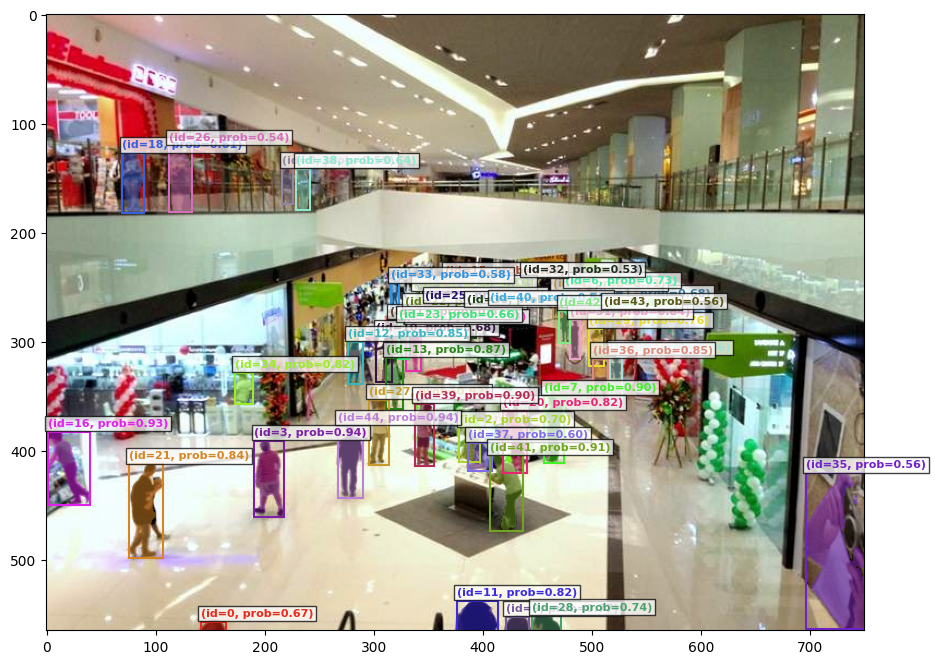

In [6]:
from sam3.visualization_utils import plot_results
plot_results(image, inference_state)

# Video

In [7]:
import yt_dlp

url = "https://www.facebook.com/watch/?v=316432954521369"
output_filename = "/root/VLM-high-resolution/video.mp4"
ydl_opts = {
    "outtmpl": output_filename,
    "format": "best",
}

with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    ydl.download([url])

[facebook] Extracting URL: https://www.facebook.com/watch/?v=316432954521369
[facebook] 316432954521369: Downloading webpage
[info] 316432954521369: Downloading 1 format(s): hd
[download] /root/VLM-high-resolution/video.mp4 has already been downloaded
[download] 100% of    4.59MiB


In [8]:
from sam3.model_builder import build_sam3_video_predictor
video_predictor = build_sam3_video_predictor()

INFO 2025-12-11 15:31:12,720 9065 sam3_video_predictor.py: 299: using the following GPU IDs: [0]
INFO 2025-12-11 15:31:12,722 9065 sam3_video_predictor.py: 315: 


	*** START loading model on all ranks ***


INFO 2025-12-11 15:31:12,722 9065 sam3_video_predictor.py: 317: loading model on rank=0 with world_size=1 -- this could take a while ...
INFO 2025-12-11 15:31:19,713 9065 sam3_video_base.py: 124: setting max_num_objects=10000 and num_obj_for_compile=16
INFO 2025-12-11 15:31:21,722 9065 sam3_video_predictor.py: 319: loading model on rank=0 with world_size=1 -- DONE locally
INFO 2025-12-11 15:31:21,723 9065 sam3_video_predictor.py: 330: 


	*** DONE loading model on all ranks ***




In [ ]:
video_path = "/root/VLM-high-resolution/video.mp4"
response = video_predictor.handle_request(
    request=dict(
        type="start_session",
        resource_path=video_path,
    )
)
session_id = response["session_id"]
prompt_response = video_predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=0,
        text="person",
    )
)

outputs = prompt_response["outputs"]

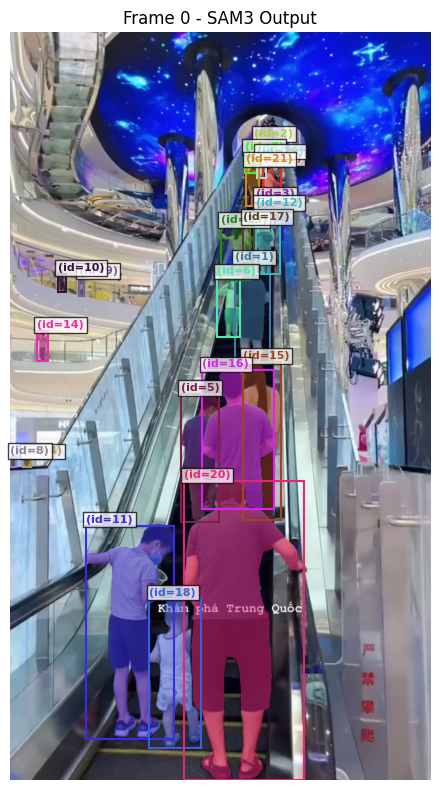

In [10]:
import cv2
import glob
from sam3.visualization_utils import (
    prepare_masks_for_visualization,
    visualize_formatted_frame_output,
)

if isinstance(video_path, str) and video_path.endswith(".mp4"):
    cap = cv2.VideoCapture(video_path)
    video_frames_for_vis = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        video_frames_for_vis.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()
else:
    video_frames_for_vis = glob.glob(os.path.join(video_path, "*.jpg"))
    try:
        video_frames_for_vis.sort(
            key=lambda p: int(os.path.splitext(os.path.basename(p))[0])
        )
    except ValueError:
        print(
            f'frame names are not in "<frame_index>.jpg" format: {video_frames_for_vis[:5]=}, '
            f"falling back to lexicographic sort."
        )
        video_frames_for_vis.sort()

visualize_formatted_frame_output(
    0,
    video_frames_for_vis,
    outputs_list=[prepare_masks_for_visualization({0: outputs})],
    titles=["SAM3 Output"]
)